### Constant Definition      

In [12]:
%pylab inline 
warnings.filterwarnings("ignore")
np.printoptions(precision=2)
import numpy as np
import pandas as pd
from scipy.optimize import minimize,minimize_scalar
# constant variable definition 
beta = 1/(1+0.02)

# States of the economy, GOOD or BAD, {1 : GOOD}, {0 : BAD}
S = [0,1]
# current risk free interest rate 
r_f = [0.01 ,0.03]
# All the money amount are denoted in thousand dollars
earningShock = [0.9,1.1]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6 
P = np.array([[0.6, 0.4],[0.2, 0.8]])
# time line
T_min = 20
T_max = 80
T_y = 65
T = T_max - T_min
# All the money amount are denoted in thousand dollars
earningShock = [0.9,1.1]
# Define earning profile 
start = 4
high = 12
retire = 4

# Define the utility function 
def u(c):
    return np.log(c)

def chi(age, s):
    start = 4
    high = 12
    retire = 4
    return y[age-T_min-1]*earningShock[int(s)]

# Define the transition of state 
def transition(Z, a):
    '''
        Input: Z is a tuple containing states variables: (w, s) which is the current wealth and econ state
               a is the action taken with contains variables: (c, b) which is the combination of consumption, bond and stock
        Output: the next possible states with corresponding probabilities
    '''
    w, s = Z
    c, b = a
    # collect possible next state (w_next, s_next) with probability prob
    Z_next = []
    prob = []
    # depend on the current econ state s and future state s_next we have the following return on bond and stock 
    for s_next in S:
        r_bond = r_f[int(s)]
        w_next = b*(1+r_bond)
        Z_next.append([w_next, s_next])
        prob.append(P[int(s), s_next])
    return np.array(Z_next), np.array(prob)

# Definition of the value function, return of the funciton is the value of the function and the coresponding policy
def V(w, s, t, model): 
    def obj(c):
        b = chi(t,s) + w - c
        if c <= 0 or b <= 0:
            return 9999999999
        else:
            Z_next, prob = transition([w , s], (c, b))
            V_next = np.array([model[int(z[1])](z[0]) for z in Z_next])
            return -(u(c) + beta * np.dot(V_next, prob))
    res = minimize_scalar(obj)
    return [-res.fun, res.x, chi(t,s) + w-res.x]

Populating the interactive namespace from numpy and matplotlib


### value iteration

In [7]:
# Define the grid of wealth
Nw = 500; 
w_min =  0; 
w_max = 200;
wgrid = np.linspace(w_min,w_max, Nw)
# Place holder for value and policy 
b_T = np.zeros((Nw, 2));
c_T = np.zeros((Nw, 2));
c_T[:, 0] = wgrid + chi(T_max,0);
c_T[:, 1] = wgrid + chi(T_max,1);
V_T = np.log(c_T);

V_t = np.zeros((Nw,len(S),T))
C_t = np.zeros((Nw,len(S),T))
B_t = np.zeros((Nw,len(S),T))

V_t[:,:,T-1] = V_T
C_t[:,:,T-1] = c_T
B_t[:,:,T-1] = b_T

In [8]:
# Set value to the grid by backward induction 
from scipy.interpolate import interp1d
from multiprocessing import Pool
from functools import partial 

pool = Pool()

for t in range(T_max-2, T_min-1, -1):
    print(t)
    tt = t-T_min
    cs = [interp1d(wgrid, V_t[:,:,tt+1][:,0], kind = "cubic", fill_value="extrapolate"),
          interp1d(wgrid, V_t[:,:,tt+1][:,1], kind = "cubic", fill_value="extrapolate")] 
    for s in S:
        f = partial(V, s = s, t = t, model = cs)
        results = np.array(pool.map(f, wgrid))
        V_t[:,:,tt][:,s] = results[:,0]
        C_t[:,:,tt][:,s] = results[:,1]
        B_t[:,:,tt][:,s] = results[:,2]
pool.close()

78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20


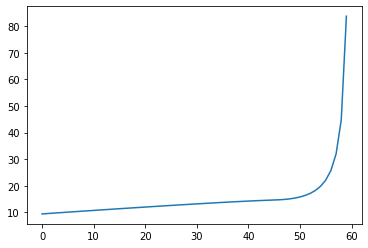

In [27]:
plt.plot(C_t[200,0,:])

### simulation part

In [4]:
import quantecon as qe
def mc_sample_path(P, x0=None, sample_size=1000):

    # set up
    P = np.asarray(P)
    X = np.empty(sample_size, dtype=int)

    # Convert each row of P into a cdf
    n = len(P)
    P_dist = [np.cumsum(P[i, :]) for i in range(n)]

    # draw initial state, defaulting to 0
    if x0 is not None:
        X_0 = qe.random.draw(np.cumsum(x0))
    else:
        X_0 = 0

    # simulate
    X[0] = X_0
    for t in range(sample_size - 1):
        X[t+1] = qe.random.draw(P_dist[X[t]])

    return X

def action(C_t, t, w, s):
    w_grid = np.linspace(w_min, w_max, num = Nw)
    p = C_t[:,s,t]
    return interp1d(wgrid, p, kind = "cubic",  fill_value="extrapolate")(w)
    
# Define the transtiion of state 
def fixTransition(w, t, s, c):
    # depend on the current econ state s and future state s_next we have the following return on bond and stock 
    r_bond = r_f[int(s)]
    w_next = (chi(t+T_min,s) + w - c)*(1+r_bond)
    return w_next

In [21]:
# importing pandas as pd  
simulations = 1000
for sim in range(simulations):
    if sim%100 == 0:
        print(sim)
    # simulate an agent age 15 starting with wealth of 30
    w = 0
    wealth = []
    Consumption = []
    Bond = []
    Stock = []
    Income = []
    econState = mc_sample_path(P, sample_size=T_max-T_min+1)
    for t in range(len(econState)-1):
        wealth.append(w)
        s = econState[t]
        c = action(C_t, t, w, s)
        Consumption.append(c)
        Bond.append(chi(t+T_min,s) + w - c)
        Income.append(chi(t+T_min,s))
        w = fixTransition(w, t, s, c)
    # dictionary of lists  
    dictionary = {'wealth': np.round(wealth,2),'Consumption': np.round(Consumption,2), 
                  'Bond': np.round(Bond), 'Income':np.round(Income,2)}  
    if sim == 0:
        df = pd.DataFrame(dictionary) 
    else:
        df = df + pd.DataFrame(dictionary) 

0
100
200
300
400
500
600
700
800
900


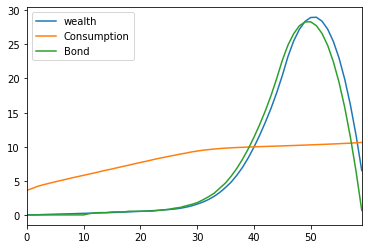

In [9]:
%notebook inline
df_average = df/simulations
df_average.plot()

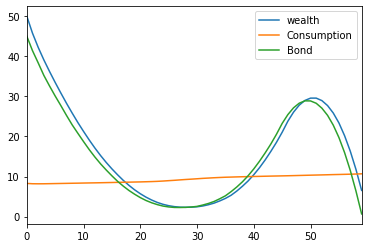

In [11]:
df_average2 = df/simulations
df_average2.plot()

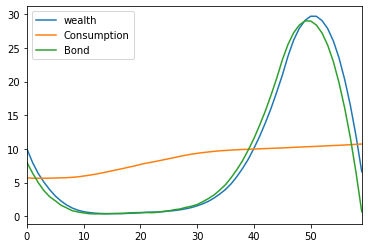

In [13]:
df_average3 = df/simulations
df_average3.plot()

In [22]:
#(b(t) - b(t-1))/y(t)
df_average3 = df/simulations

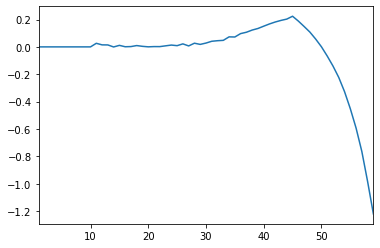

In [23]:
# hand to mouth 
(df_average3.Bond.diff()/(df_average3.Income))[1:].plot()

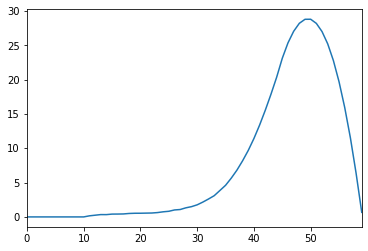

In [25]:
df_average3.Bond.plot()

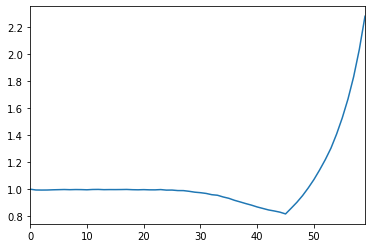

In [26]:
(df.Consumption/df.Income).plot()